# Idealista API

Access is free to a maximum of 100 req/month and it’s limited by 1 req/sec.

In [4]:
import httpx
import base64
import os

# %% Request auth token
message = os.environ.get('IDEALISTA_API_KEY', '') + ":" + os.environ.get('IDEALISTA_API_SECRET', '')
auth = "Basic " + base64.b64encode(message.encode("ascii")).decode("ascii")

headers_dic = {"Authorization": auth,
               "Content-Type": "application/x-www-form-urlencoded;charset=UTF-8"}

params_dic = {"grant_type": "client_credentials",
              "scope": "read"}

r = httpx.post("https://api.idealista.com/oauth/token",
                  headers=headers_dic,
                  params=params_dic)

In [5]:
from typing import Final

token = r.json()
access_token = token['access_token']

BASE_URL: Final[str] = "https://api.idealista.com/3.5/es/search"
headers = {'Authorization': 'Bearer ' + access_token}

lat: float = 40.488810
lon: float = -3.365879
distance: float = 5e3

params = {
    'center': f'{lat},{lon}',
    'country': 'es',
    'maxItems': '100',
    'numPage': '1',
    'distance': distance,
    'propertyType': 'homes',
    # 'maxPrice': 400e3,
    'operation': 'sale',  # rent
}

response = httpx.post(BASE_URL, headers=headers, params=params)

data = response.json()
print(f'Total pages: {data['totalPages']}')

Total pages: 9


In [6]:
from tqdm import tqdm

pages = [data]

if data['totalPages'] > 1:
    for i in tqdm(range(2, data['totalPages'] + 1)):
        params['numPage'] = i
        response = httpx.post(BASE_URL, headers=headers, params=params)

        pages.append(response.json())

  0%|          | 0/8 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import json

with open('data/alcala.json', 'w') as f:
    json.dump([el for item in pages for el in item["elementList"]], f)

## Exploratory Data Analysis

In [7]:
import pandas as pd

df = pd.read_json('data/alcala.json')

(0.0, 7162080.0)

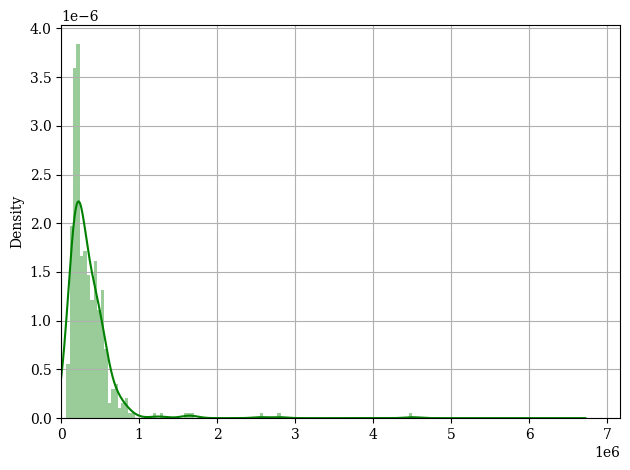

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df['price'].plot.density(ax=ax, color='g')
df['price'].hist(ax=ax, bins=100, density=True, color='g', alpha=.4)
ax.set_xlim(left=0)

<Axes: >

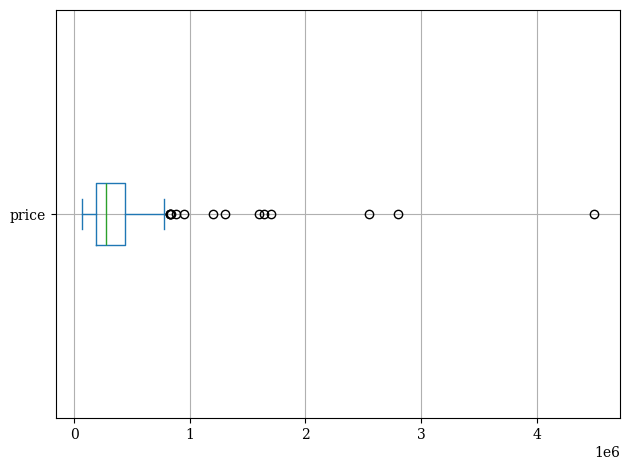

In [9]:
df['price'].plot.box(vert=False, grid=True)

In [10]:
print(f"El primer cuartil es: {df['price'].quantile(.25):.2f}")
print(f"La mediana es: {df['price'].median():.2f}")
print(f"El tercer cuartil es: {df['price'].quantile(.75):.2f}")
print(f"La media es: {df['price'].mean():.2f}")
print(f"La desv. est. es: {df['price'].std():.2f}")

El primer cuartil es: 190000.00
La mediana es: 272450.00
El tercer cuartil es: 441335.00
La media es: 352391.21
La desv. est. es: 327334.11


<Axes: xlabel='size', ylabel='price'>

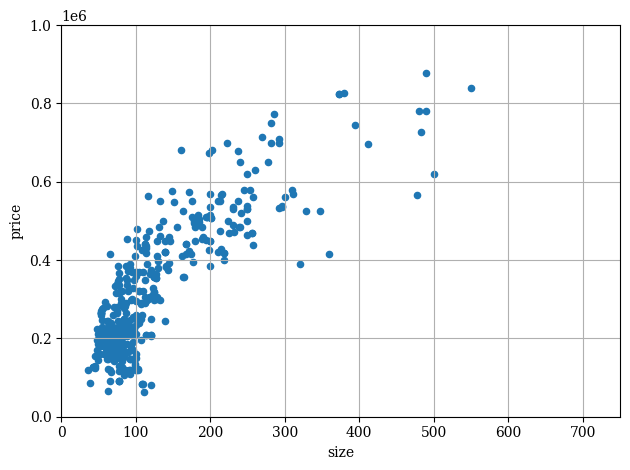

In [11]:
df.plot.scatter(x='size', y='price', grid=True, xlim=[0, 750], ylim=[0, 1e6])

In [21]:
import plotly.express as px

fig = px.scatter_map(df.query("price<5e5"), lat="latitude", lon="longitude", color="price", size="size", zoom=13) 
fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    # map_style="satellite-streets"
)
fig.show()

In [13]:
df['eur_m2']=df['price']/df['size']

fig = px.scatter_map(df.query("price<5e5"), lat="latitude", lon="longitude", color="eur_m2", size='size', zoom=13)
fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    map_style="carto-positron"
)
fig.show()

In [47]:
# px.scatter(df['size'], df['price'])
df_ = df.query('size < 200')
px.scatter(df_, x='size', y='price') #, log_x=True, log_y=True)

## Mínimos cuadrados ordinarios (OLS)

Se usará la librería [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html).

In [127]:
import statsmodels.api as sm

y = df_['price'].to_numpy()
X = df_[['size']].to_numpy()

# Añadir intercepto
X = sm.add_constant(X)

In [128]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     423.9
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           7.43e-63
Time:                        16:04:32   Log-Likelihood:                -4614.3
No. Observations:                 363   AIC:                             9233.
Df Residuals:                     361   BIC:                             9240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.824e+04   1.23e+04      2.303      0.022    4125.215    5.23e+04
x1          2503.7736    121.608     20.589      0.000    2264.625    2742.922
==============================================================================
Omnibus:                        4.038   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                4.746
Skew:                           0.079   Prob(JB):                       0.0932
Kurtosis:                       3.537   Cond. No.                         293.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

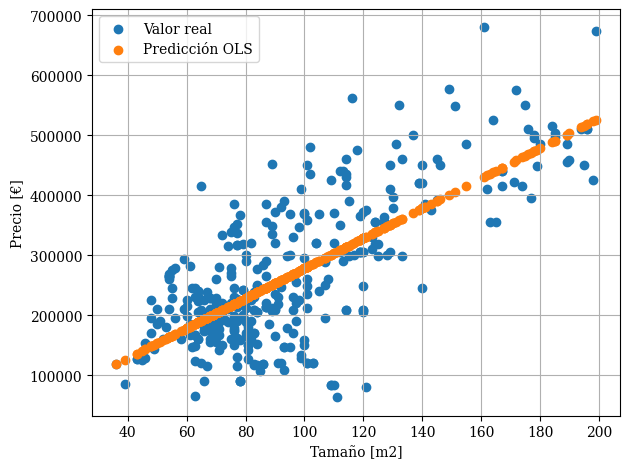

In [129]:
y_pred = results.predict(X)

fig, ax = plt.subplots()
ax.scatter(df_['size'], y, label='Valor real')
ax.scatter(df_['size'], y_pred, label='Predicción OLS')
ax.set_xlabel('Tamaño [m2]')
ax.set_ylabel('Precio [€]')

ax.legend()

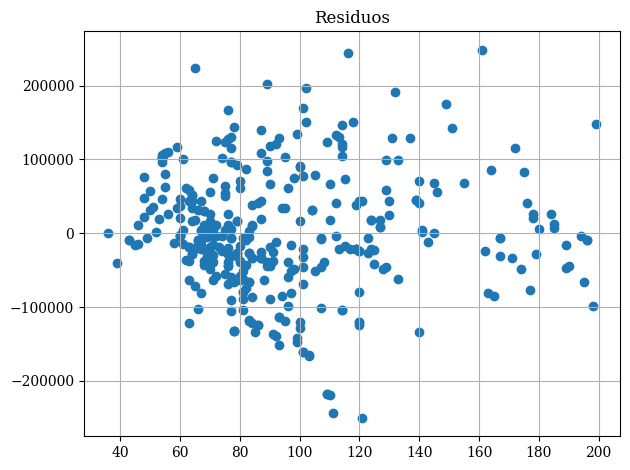

In [137]:
# Residuos del modelo
plt.scatter(X[:,1], y-y_pred)
plt.title('Residuos');

### Otros parámetros

In [138]:
def floor_group(x):
    if x == 'bj':
        return 'Bajo'
    elif x == 'en':
        return 'Entreplanta'
    else:
        return 'Plantas superiores'

df['floor_group'] = df['floor'].apply(floor_group)

<Axes: ylabel='Precio por m2'>

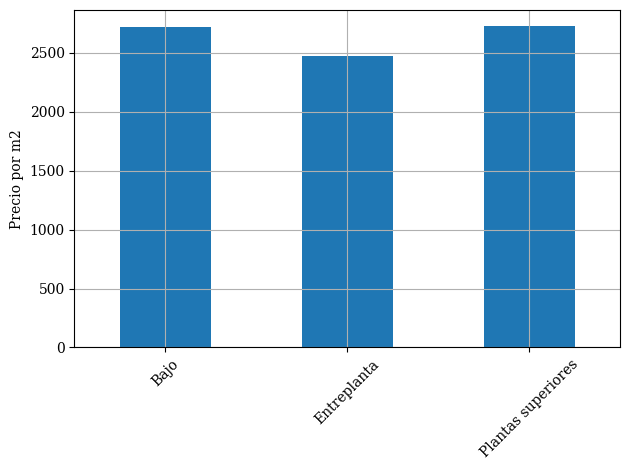

In [139]:
df.groupby('floor_group')['eur_m2'].mean().plot.bar(rot=45, xlabel='', ylabel='Precio por m2')

In [144]:
import statsmodels.api as sm

y = df_['price']
X = df_[['size', 'rooms', 'bathrooms', 'hasLift']]

mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

# Añadir intercepto
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     167.3
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           2.33e-78
Time:                        16:05:49   Log-Likelihood:                -4208.4
No. Observations:                 338   AIC:                             8427.
Df Residuals:                     333   BIC:                             8446.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.235e+04   1.25e+04      1.791      0.074   -2198.191    4.69e+04
size        1549.9461    178.273      8.694      0.000    1199.264    1900.628
rooms      -1.781e+04   5113.724     -3.482      0.001   -2.79e+04   -7746.023
bathrooms   7.049e+04   9001.882      7.831      0.000    5.28e+04    8.82e+04
hasLift       6.3e+04   7632.384      8.255      0.000     4.8e+04     7.8e+04
==============================================================================
Omnibus:                       22.565   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.663
Skew:                          -0.343   Prob(JB):                     4.47e-11
Kurtosis:                       4.707   Cond. No.                         371.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""